# Librerias

In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils as u
import re
import geopandas as gpd
import ast

pd.options.display.max_columns = None

# Limpieza de Datos

Nuestra base principal es la base de los restaurantes de google maps, lo que haremos será unificar las 4 fuentes en un mismo dataframe para poder modelar.

In [331]:
''' 
Lectura de datos de detalle de sitios de Madrid.
'''
detalle_restaurantes = pd.read_csv('../data/raw/detalle_sitios.csv')

In [332]:
''' 
Lectura de datos de id de sitios y sus nombres.
'''

restaurantes = pd.read_csv('../data/raw/lugares_madrid.csv')

In [333]:
restaurantes = pd.merge(restaurantes, detalle_restaurantes, left_on='id', right_on='place_id') # Unimos las 2 fuentes por el place_id

In [334]:
restaurantes.drop(['id', 'summary'], inplace=True, axis=1) # Quitamos las  variables de id y summary de dataframe
restaurantes = restaurantes[restaurantes['rating'].notnull()] # Quitamos los restaurantes que tienen rating vacios

In [335]:
print('Distribución de precios:\n')
print(restaurantes['price_level'].value_counts(dropna=False), '\n')
print('Total de registros:', len(restaurantes['price_level']))

Distribución de precios:

price_level
1.0    1064
NaN     723
2.0     637
3.0     104
4.0      16
Name: count, dtype: int64 

Total de registros: 2544


In [336]:
''' 
Vamos hacer un proceso de limpieza para el dataframe y vamos a asumir cierto valores para los registros sin datos.
- todas las variables booleanas según cada un asumiremos que los valores vacios son verdaderos o falsos.
- dine_in: Comer dentro del restaurante todos los vacios asumimos que son True (lo más común).
- reservable: Si se puedo o no hacer reservas es dificil determinar su valor pero asumimos que es Falso. 
- serves_beer: Si sirve cerveza, asumimos que siempre. 
- serves_breakfast: Sirven desayunos, asumimos que no ya que lo común es que sea almuerzos o cena. 
- serves_brunch:Sirven brunch, asumimos que no ya que lo común es que sea almuerzos o cena. 
- serves_dinner: Sirven cena, asumimos que si ya que lo común es que sea almuerzos o cena. 
- serves_lunch: Sirven almuerzo, asumimos que si ya que lo común es que sea almuerzos o cena. 
- serves_vegetarian_food: Sirven comida vegetariana, asumimos que no ya que no es aun tan común aquí en Madrid. 
- serves_wine: Si sirve vino, asumimos que siempre.
- takeout: Si sirven para llevar asumimos que si suelen permitir.
- delivery: Asumimos que no hacen delivery.
- price_level: para el precio asumimos que tiene el precio que más se repite que es
'''

restaurantes['dine_in'] = restaurantes['dine_in'].astype(bool).fillna(True).astype(int)
restaurantes['price_level'] = restaurantes['price_level'].fillna(1)
restaurantes['reservable'] = restaurantes['reservable'].astype(bool).fillna(False).astype(int)
restaurantes['serves_beer'] = restaurantes['serves_beer'].astype(bool).fillna(True).astype(int)
restaurantes['serves_breakfast'] = restaurantes['serves_breakfast'].astype(bool).fillna(False).astype(int)
restaurantes['serves_brunch'] = restaurantes['serves_brunch'].astype(bool).fillna(False).astype(int)
restaurantes['serves_dinner'] = restaurantes['serves_dinner'].astype(bool).fillna(True).astype(int)
restaurantes['serves_lunch'] = restaurantes['serves_lunch'].astype(bool).fillna(True).astype(int)
restaurantes['serves_vegetarian_food'] = restaurantes['serves_vegetarian_food'].astype(bool).fillna(False).astype(int)
restaurantes['serves_wine'] = restaurantes['serves_wine'].astype(bool).fillna(True).astype(int)
restaurantes['takeout'] = restaurantes['takeout'].astype(bool).fillna(True).astype(int)
restaurantes['delivery'] = restaurantes['delivery'].astype(bool).fillna(False).astype(int)

In [337]:
restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2544 entries, 0 to 2627
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nombre                  2544 non-null   object 
 1   lat                     2544 non-null   float64
 2   lon                     2544 non-null   float64
 3   place_id                2544 non-null   object 
 4   dine_in                 2544 non-null   int64  
 5   address                 2544 non-null   object 
 6   price_level             2544 non-null   float64
 7   rating                  2544 non-null   float64
 8   reservable              2544 non-null   int64  
 9   serves_beer             2544 non-null   int64  
 10  serves_breakfast        2544 non-null   int64  
 11  serves_brunch           2544 non-null   int64  
 12  serves_dinner           2544 non-null   int64  
 13  serves_lunch            2544 non-null   int64  
 14  serves_vegetarian_food  2544 non-null   int64

Una vez con todos los valores sin nulos, vamos a crear una variables para el modelo basadas en las localización del restaurante, para esto tenemos que primero tansformar el dataframe en un dataframe geo espacial de Geopandas.

In [338]:
''' 
Creamos un dataframe geoespacial donde los puntos de geometria es la latitud y logitud. Esta medidas tiene un valor de crs 
(Coordinate Reference System of the geometry objects) de 4326 que hace referencia a la latitud y logitud.
'''

restaurantes_geo = gpd.GeoDataFrame(restaurantes, geometry=gpd.points_from_xy(restaurantes['lon'], restaurantes['lat']), crs='EPSG:4326')

Una vez convertido en geopandas, primero vamos hacer un mapping a que barrio y distrito pertenece cada restaurante. Para esto utilizaremos la información del ayuntamiento de Madrid que viene detallado en un json la geometría de cada barrio.

In [339]:
''' 
Lectura de geometria de barrios y las transformamos en geopandas con un crs de 4326 para poder mapear con nuestro dataframe de restaurantes_geo.
'''
barrios = gpd.read_file('../data/raw/Barrios.json') # lectura
barrios = gpd.GeoDataFrame(barrios, geometry='geometry', crs='EPSG:4326') # Determinar la geometria

In [340]:
'''
Una vez unficado las 2 fuentes en la misma métricas vamos a hacer un join espacial donde miramos de la geometria de los restaurantes en que barrio
se encuentra dentro o intersecan.
Quitamos variables que no necesitamos.
'''

restaurantes_geo = gpd.sjoin(restaurantes_geo, barrios, how='left', predicate='intersects')
restaurantes_geo.drop(['index_right', 'id', 'Shape_Leng', 'Shape_Area','FCH_ALTA', 
                       'FCH_BAJA', 'OBSERVACIO', 'APROBACION', 'COD_DIS_TX', 'COD_DISB',
                       'BARRIO_MAY','BARRIO_MT', 'COD_DISBAR', 'NUM_BAR'], axis=1 , inplace=True)

Ahora que ya tenemos los barrios y distritos mapeados para cada restaurante, vamos a crear variables de:
- Media de precio de los restaurantes cerca de 2km.
- Media de rating de los restaurantes cerca de 2km.
- Media de comentarios de los restaurantes cerca de 2km.

Para hace esto, tenemos que unir el dataframe geo espacial de restaurantes con la misma base, pero creamos un campo nuevo que hace un buffer (poligono geoespacial de todos los puntos dentro de un radio) de manera que se pueda mirar que restaurantes están dentro de este radio.

Para esto tenemos que cambiar la geometría de dataframe a un crs de 25830 seudonimo en distancia en metros.

In [341]:
restaurantes_geo = restaurantes_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros para España

In [342]:
''' 
Creamos una copia del dataframe de restarantes para crearlo con el buffer de los 2 km.
'''
restaurantes_geo_buffer = restaurantes_geo.copy() #copia de df
restaurantes_geo_buffer['buffer_2000'] = restaurantes_geo_buffer.geometry.buffer(2000) #creamos el campo de buffer
restaurantes_geo_buffer = restaurantes_geo_buffer.set_geometry('buffer_2000') #cambiamos la geometría del dataframe para que sea el buffer

In [343]:
restaurantes_geo.drop(['nombre','lat', 'lon', 'dine_in', 'address', 'reservable', 'serves_beer', 'serves_breakfast',
       'serves_brunch', 'serves_dinner', 'serves_lunch',
       'serves_vegetarian_food', 'serves_wine', 'takeout', 'delivery',
       'CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE'], axis=1, inplace=True) #quitamos ciertas variables para que no se repitan

In [344]:
'''
Una vez unficado los 2 dataframes  en la misma métricas vamos a hacer un join espacial donde miramos de la geometria de los restaurantes en que barrio
se encuentra dentro o intersecan.
Quitamos variables que no necesitamos.
'''

result_restaurantes = gpd.sjoin(restaurantes_geo, restaurantes_geo_buffer, how='right', predicate='intersects')
result_restaurantes.drop('index_left', axis=1, inplace=True)

In [345]:
''' 
Una vez unidos vamos a agrupar por restaurante y calculamos las medidas antes mencionadas.
- Media de precio de los restaurantes cerca de 2km.
- Media de rating de los restaurantes cerca de 2km.
- Media de comentarios de los restaurantes cerca de 2km.
'''

result = result_restaurantes.groupby(['place_id_right','CODDIS', 'NOMDIS','COD_BAR', 'NOMBRE'])[['price_level_left', 'rating_left', 'user_ratings_total_left']].mean().reset_index()
result.rename({'place_id_right':'place_id',
               'price_level_left':'price_level_mean',
               'rating_left':'rating_mean',
               'user_ratings_total_left':'user_ratings_mean'}, axis=1, inplace=True)

In [346]:
restaurantes = pd.merge(restaurantes, result, how='left', left_on='place_id', right_on='place_id') # Unimos las nuevas columnas en nuestro df de restaurantes

In [347]:
restaurantes['COD_BAR'] = restaurantes['COD_BAR'].astype('int') # Quitamos los ceros antes de los codigos de barrio
restaurantes['COD_BAR'] = restaurantes['COD_BAR'].astype('str')

Ahora que ya tenemos los códigos de barrios mapeado para cada restaurante, podemos unir con la información de distintos indicadores de cada barrio de Madrid. Con esta fuente podemos tenemos una idea de tipo de vida media que tienen cada sitio.

In [348]:
''' 
Lectura de datos de kpi de barrios Madrid.
'''

kpi = pd.read_csv('../data/raw/kpi_barrios_madrid.csv')

In [349]:
kpi['cod_barrio'] = kpi['cod_barrio'].astype('int') # Quitamos los ceros antes de los codigos de barrio
kpi['cod_barrio'] = kpi['cod_barrio'].astype('str')

In [350]:
''' 
Al ser una fuente de España los decimales se marcan con , y tenemos que reemplazarlos con .
'''

kpi['valor_indicador'] = kpi['valor_indicador'].str.replace(',', '.').astype('float')
kpi['valor_indicador'] = kpi['valor_indicador'].fillna(0) #rellenamos los datos vacios con 0

In [351]:
''' 
Pivotamos la tabla para que los indicadores sea columnas y las rellenamos con 0 los nulls.
'''

kpi = kpi.pivot(index='cod_barrio', columns='indicador_completo', values='valor_indicador').reset_index()
kpi.fillna(0, inplace=True)

In [352]:
restaurantes = pd.merge(restaurantes, kpi, how='left', left_on='COD_BAR', right_on='cod_barrio') # Unimos los indicadores en la base de restaurantes

Ahora nos queda solo unir una fuente más para nuestra base de restaurantes, que es el tipo de cocina. Esta información no viene desde google maps, por lo que acudimos a Open Street Map, pero el problema principal es que estos datos al ser una API gratuita depende de voluntarios y usuarios que suben los datos por lo que los datos no siempre están completos ni actualizados, por lo que usaremos estos datos para crear un modelo predictivo de clasificación que identifique por le nombre del restaurante el tipo de comida que vende.

In [353]:
''' 
Lectura de datos de reataurantes de toda España.
'''

street_map = pd.read_csv('../data/raw/sitios_streetmap.csv')

In [354]:
street_map = street_map[(street_map['cocina'].notnull())&(street_map['nombre'].notnull())] # nos quedamos con los registros que la cocina no sea vacia ni su nombre

In [355]:
street_map['cocina'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['cocina']] # Hacemos una limpieza previa del tipo de cocina para quitar los caracteres especiales

In [356]:
''' 
Hemos creado una diccionario que mapea el tipo de cocina con una agrupación de cada cocina. 
Este archivo lo cargamos y lo leemos como diccionario.
'''

with open('../data/raw/tipo_cocina.txt', 'r', encoding="utf-8") as file:
    data = file.read()

tipos_cocina = ast.literal_eval(data) #Convertimos a diccionario

In [357]:
''' 
Mapeamos en el data frame de open street map el tipo de cocina y nos quitamos los registro nulos.
'''

street_map['cocina_map'] = street_map['cocina'].map(tipos_cocina)
street_map = street_map[street_map['cocina_map'].notnull()]

In [358]:
''' 
Limpieza de nombre de restaurante para el modelo, quitamos tildes y caracteres especiales.
'''

street_map['nombre'] = street_map['nombre'].apply(u.eliminar_acentos)
street_map['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in street_map['nombre']]

Creamos un pipeline de distintos modelos para ver que mejor se ajusta a nuestro modelo.

In [359]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = street_map['nombre']
y = street_map['cocina_map']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

pipe = Pipeline(steps=[("scaler", CountVectorizer()),
    ('classifier', MultinomialNB())
])

logistic_params = {
    'scaler':[CountVectorizer()],
    'classifier': [LogisticRegression(max_iter=10000, solver='liblinear'), LogisticRegression(max_iter=10, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}

random_forest_params = {
    'scaler': [CountVectorizer()],
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': np.arange(2, 9),
    'classifier__n_estimators': [100, 200, 500],
}

naive_param = {
    'scaler': [CountVectorizer()],
    'classifier': [MultinomialNB()],
    'classifier__alpha': [0.28, 0.30, 0.31],
}

cnaive_param = {
    'scaler': [CountVectorizer()],
    'classifier': [ComplementNB()],
    'classifier__alpha': [0.1, 0.25, 0.50, 0.75, 0.80, 1],
}

search_space = [
    logistic_params,
    random_forest_params,
    naive_param,
    cnaive_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 5,
                  n_jobs=-1)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=10000,
                                                            solver='liblinear'),
                                         LogisticRegression(max_iter=10,
                                                            solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2'],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                          'classifier__n_estimators': [100, 200, 500],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.28, 0.3, 0.31],
                          'scaler': [CountVectorizer()]},
                         {'classifier': [ComplementNB()],
                          'classifier__alpha': [0.1, 0.25, 0.5, 0.75, 0.8, 1],
                          'scaler': [CountVectorizer()]}])

In [360]:
''' 
De todos los modelos que probamos usaremos el modelo de MultinomialNB (bayesianos), que son los que mejor se 
ajustan a modelos de prediccion de textos. 

'''

print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaler', CountVectorizer()),
                ('classifier', MultinomialNB(alpha=0.3))])
0.7347621613278077
{'classifier': MultinomialNB(), 'classifier__alpha': 0.3, 'scaler': CountVectorizer()}


In [361]:
''' 
Evaluamos el modelo en nuestro test.
'''

cocina_mod = clf.best_estimator_
y_pred = cocina_mod.predict(X_test)

cocina_mod.score(y_test, y_pred)

0.769690927218345

Nuestro modelo no es del todo preciso pero vamos a trabajar con el para nuestro modelo final, por lo que hacemos una nueva columna con el tipo de comida de cada restaurante.

In [362]:
''' 
Pre procesamos los datos de nombre del restaurantes para poder hacer la predicción  quitando las tildes y caracteres especiales.
'''

restaurantes['nombre'] = restaurantes['nombre'].apply(u.eliminar_acentos)
restaurantes['nombre'] = [re.sub(r'[^a-zA-Z0-9\s]', ' ', i.lower()) for i in restaurantes['nombre']]

In [363]:
restaurantes['tipo_cocina']  = cocina_mod.predict(restaurantes['nombre']) # Creamos columna de tipo de cocina con el modelo

Según el modelo elegido para nuestro proyecto, ciertas varaibles es necesarios preprocesarlas para que se puedas incluir en la analítica. Estos preprocesos puedes ser convertir en dummies (Una variable que solo toma dos valores → 0 o 1) o codificar sus nombres en numeros.

In [364]:
''' 
Proceso para crear las variables dummies de:
- Tipo de cocina.
- Nombre distrito.
- Nombre de barrio.
'''

from sklearn.preprocessing import OneHotEncoder

enc_cocina = OneHotEncoder(handle_unknown='ignore')
tip_coci= enc_cocina.fit_transform(restaurantes[['tipo_cocina']]).toarray()
tip_cocina_dummy = pd.DataFrame(tip_coci, columns=[cat for cat in enc_cocina.categories_[0]])

enc_distrito = OneHotEncoder(handle_unknown='ignore')
tip_distrito= enc_distrito.fit_transform(restaurantes[['NOMDIS']]).toarray()
tip_distrito_dummy = pd.DataFrame(tip_distrito, columns=[cat for cat in enc_distrito.categories_[0]])

enc_barrio = OneHotEncoder(handle_unknown='ignore')
tip_barrio= enc_barrio.fit_transform(restaurantes[['NOMBRE']]).toarray()
tip_barrio_dummy = pd.DataFrame(tip_barrio, columns=[cat for cat in enc_barrio.categories_[0]])

restaurantes = pd.concat([restaurantes, tip_cocina_dummy, tip_distrito_dummy, tip_barrio_dummy], axis=1)

In [365]:
restaurantes.drop(['cod_barrio', 'NOMDIS', 'NOMBRE', 
                   'Población en etapa educativa (Población de 0 a 16 años -16 no incluidos)',
                   'Primera y segunda nacionalidad extranjera en el Distrito: CHINA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: CHINA (Población total Distrito)',
                   'Primera y segunda nacionalidad extranjera en el Distrito: COLOMBIA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: FILIPINAS (Población total Distrito)',
                   'Primera y segunda nacionalidad extranjera en el Distrito: FRANCIA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: HONDURAS',
                   'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: ITALIA (Total en Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: MARRUECOS (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PARAGUAY',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PARAGUAY (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PERÚ',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: PERÚ (Población total Distrito)',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: RUMANÍA',
                   'Primera y segunda nacionalidad extranjera en el Distrito: VENEZUELA',	
                   'Primera y segunda nacionalidad extranjera en el Distrito: VENEZUELA (Población total Distrito)',
                   'Tasa absoluta de paro registrado hombres',
                   'Tasa absoluta de paro registrado mujeres',
                   'Primera y segunda nacionalidad extranjera en el Distrito: FILIPINAS',
                   'Primera y segunda nacionalidad extranjera en el Distrito: \nMARRUECOS (Población total Distrito)',
                   'Duración media del crédito (meses) en transacción de vivienda (2019)'
                   ], axis=1, inplace=True) # quitamos ciertas columnas que no necesitamos.

In [366]:
''' 
Renombramos las columnas a nombres mas faciles.
'''

restaurantes.rename(columns={
                    'nombre':'nombre_restaurante',
                    'address':'direccion',
                    'CODDIS':'cod_distrito',
                    'COD_BAR':'cod_barrio',
                    'Apartamentos Municipales para Mayores':'apt_municip_mayores',
                    'Asociaciones (Sección 1ª)':'asocia_sec_1',
                    'Asociaciones culturales y casas regionales':'asocia_cult_casas_reg',
                    'Asociaciones de mujeres':'asocia_mujeres',
                    'Asociaciones vecinales':'asocia_vecinales',
                    'Año medio de contrucción de inmuebles de uso residencial':'anio_medio_constr_vivendas',
                    'Bibliotecas Comunidad Madrid':'bibliotecas_comunidad',
                    'Bibliotecas Municipales':'bibliotecas_municipal',
                    'Bibliotecas públicas Comunidad Madrid':'bibliotecas_comunidad_public',
                    'Bibliotecas públicas Municipales':'bibliotecas_municipal_public',
                    'Campos de fútbol 11':'campus_futb_11',
                    'Centro de Día de Atención a Niños y Niñas (de 3 a 12 años)':'centro_ninos_3_12_anios',
                    'Centros Municipales de Mayores':'centro_municipal_mayor',
                    'Centros Municipales de Salud Comunitaria (CMSC)':'cmsc',
                    'Centros de Adolescentes y Jóvenes (ASPA)':'aspa',
                    'Centros de Apoyo a las Familias (CAF)':'caf',
                    'Centros de Atención a la Infancia (CAI)':'cai',
                    'Centros de Atención a las Adicciones (CAD y CCAD)':'cad_y_ccad',
                    'Centros de Día de Alzheimer y Físicos':'centro_dia_alzheimer_fisicos',
                    'Centros de Servicios Sociales':'centro_serv_social',
                    'Centros deportivos Municipales':'centro_deport_municipal',
                    'Centros para personas sin hogar':'centro_pers_sin_hogar',
                    'Centros y Espacios Culturales':'centro_espacio_cultural',
                    'Colegios Públicos Infantil y Primaria':'colegio_publ_infatil_primaria',
                    'Duración media del crédito (meses) en transacción de vivienda':'dur_media_credito_viviendas',
                    'Edad media de la población':'edad_media_poblacion',
                    'Elecciones  municipales, votos en blanco':'votos_blancos_elec_municipal',
                    'Elecciones municipales, abstenciones':'abstenciones_elec_municipal',
                    'Elecciones municipales, censo electoral':'censo_elec_municipal',
                    'Elecciones municipales, votos a Ciudadanos-Partido de la Ciudadanía':'votos_ciudadanos_elec_municipal',
                    'Elecciones municipales, votos a Más Madrid':'votos_masmadrid_elec_municipal',
                    'Elecciones municipales, votos a Más Madrid-Verdes Equo':'votos_masverdeequo_elec_municipal',
                    'Elecciones municipales, votos a Podemos-Izquierda Unida-Alianza Verde':'votos_podemos_elec_municipal',
                    'Elecciones municipales, votos a VOX':'votos_vox_elec_municipal',
                    'Elecciones municipales, votos a candidaturas':'votos_candidaturas_elec_municipal',
                    'Elecciones municipales, votos al Partido Popular':'votos_pp_elec_municipal',
                    'Elecciones municipales, votos al Partido Socialista Obrero Español':'votos_psoe_elec_municipal',
                    'Escuelas Infantiles Municipales':'escuelas_inf_municipal',
                    'Espacios de Igualdad':'espacio_igualdad',
                    'Espacios de Ocio para Adolescentes (El Enredadero)':'espacio_adolecentes_ocio',
                    'Esperanza de vida al nacer Hombres  (mortalidad del periodo 2013-2016)':'esperanza_vida_hombres',
                    'Esperanza de vida al nacer Mujeres (mortalidad del periodo 2013-2016)':'esperanza_vida_mujeres',
                    'Etapas educativas. Total niñas':'etapa_educativa_ninas',
                    'Etapas educativas. Total niños':'etapa_educativa_ninos',
                    'Fundaciones (Sección 2ª)':'fundacion_sec_2',
                    'Hogares con un hombre solo mayor de 65 años':'hogar_hombre_mas_65',
                    'Hogares con una mujer sola mayor de 65 años':'hogar_mujer_mas_65',
                    'Hogares monoparentales: un hombre adulto con uno o más menores':'hogar_monoparental_hombre',
                    'Hogares monoparentales: una mujer adulta con uno o más menores':'hogar_monoparental_mujer',
                    'Instalaciones deportivas básicas':'instalaciones_deportivas_basc',
                    'Institutos Públicos de Educación Secundaria':'inst_publico_secundaria',
                    'Mercados Municipales':'mercado_municipales',
                    'Número Habitantes':'num_habitantes',
                    'Número de inmuebles de uso residencial':'num_inmuebles_residencial',
                    'Número de locales dados de alta abiertos':'num_locales_alta_abiertos',
                    'Número de locales dados de alta cerrados':'num_locales_alta_cerrados',
                    'Número de locales dados de alta en obra':'num_locales_alta_obra',
                    'Número de locales dados de alta en uso como vivienda':'num_locales_alta_vivienda',
                    'Número de locales dados de alta totales':'num_locales_alta_tot',
                    'Paro registrado (número de personas registradas en SEPE en febrero)':'parados',
                    'Paro registrado (número de personas registradas en SEPE en febrero) hombres':'parados_hombre',
                    'Paro registrado (número de personas registradas en SEPE en febrero) mujeres':'parados_mujer',
                    'Pensión media mensual  Mujeres': 'pension_media_mensual_mujeres',
                    'Pensión media mensual Hombres':'pension_media_mensual_hombres',
                    'Personas con nacionalidad española':'personas_espanolas',
                    'Personas con nacionalidad española Hombres':'personas_espanolas_hombre',
                    'Personas con nacionalidad española Mujeres':'personas_espanolas_mujer',
                    'Personas con nacionalidad extranjera':'personas_extranjera',
                    'Personas con nacionalidad extranjera Hombres':'personas_extranjera_hombre',
                    'Personas con nacionalidad extranjera Mujeres':'personas_extranjera_mujer',
                    'Piscinas cubiertas':'piscina_cubierta',
                    'Piscinas de verano':'piscina_verano',
                    'Pista de atletismo':'pista_atletismo',
                    'Población Hombres':'poblacion_hombre',
                    'Población Mujeres':'poblacion_mujer',
                    'Población de 0 a 14 años':'poblacion_0_14',
                    'Población de 15 a 29 años':'poblacion_15_29',
                    'Población de 30 a 44  años':'poblacion_30_44',
                    'Población de 45 a 64 años':'poblacion_45_64',
                    'Población de 65 a 79 años':'poblacion_65_79',
                    'Población de 65 años y más':'poblacion_65_mas',
                    'Población de 80 años y más':'poblacion_80_mas',
                    'Población densidad (hab./Ha.)':'poblacion_densidad',
                    'Población en etapa educativa de 0 a 2 años':'poblacion_etapa_educativa_0_2',
                    'Población en etapa educativa de 12 a 15 años':'poblacion_etapa_educativa_12_15',
                    'Población en etapa educativa de 3 a 5 años':'poblacion_etapa_educativa_3_5',
                    'Población en etapa educativa de 6 a 11 años':'poblacion_etapa_educativa_6_11',
                    'Población en etapas educativas':'poblacion_etapa_educativa',
                    'Población infantil femenina en etapa educativa de 0 a 2 años':'poblacion_etapa_educativa_0_2_mujer',
                    'Población infantil femenina en etapa educativa de 12 a 15 años':'poblacion_etapa_educativa_12_15_mujer',
                    'Población infantil femenina en etapa educativa de 3 a 5 años':'poblacion_etapa_educativa_3_5_mujer',
                    'Población infantil femenina en etapa educativa de 6 a 11 años':'poblacion_etapa_educativa_6_11_mujer',
                    'Población infantil masculina en etapa educativa de 0 a 2 años':'poblacion_etapa_educativa_0_2_hombre',
                    'Población infantil masculina en etapa educativa de 12 a 15 años':'poblacion_etapa_educativa_12_15_hombre',
                    'Población infantil masculina en etapa educativa de 3 a 5 años':'poblacion_etapa_educativa_3_5_hombre',
                    'Población infantil masculina en etapa educativa de 6 a 11 años':'poblacion_etapa_educativa_6_11_hombre',
                    'Población mayor/igual  de 25 años  con estudios superiores, licenciatura, arquitectura, ingeniería sup., estudios sup. no universitarios, doctorado,  postgraduado':'pobl_25_mas_est_superiores',
                    'Población mayor/igual  de 25 años  que no sabe leer ni escribir o sin estudios':'pobl_25_mas_no_letrados',
                    'Población mayor/igual  de 25 años con Bachiller Elemental, Graduado Escolar, ESO, Formación profesional 1º grado':'pobl_25_mas_bachiller_eso_fp1',
                    'Población mayor/igual  de 25 años con Formación profesional 2º grado, Bachiller Superior o BUP':'pobl_25_mas_bachillersup_fp2',
                    'Población mayor/igual  de 25 años con Nivel de estudios desconocido y/o no consta':'pobl_25_mas_estudio_desconocido',
                    'Población mayor/igual  de 25 años con enseñanza primaria incompleta':'pobl_25_mas_primaria_incompleta',
                    'Población mayor/igual  de 25 años con titulación media, diplomatura, arquitectura o ingeniería técnica':'pobl_25_titu_media',
                    'Porcentaje de envejecimiento (Población mayor de 65 años/Población total)':'pct_evejecimiento',
                    'Porcentaje de sobre-envejecimiento (Población mayor de 80 años/ Población mayor de 65 años)':'pct_sobrevejecimiento',
                    'Posición en el ranking de distritos y/o barrios de vulnerabilidad territorial':'posicion_ranking_vulnerabilidad',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nBANGLADESH (Población total Distrito)':'poblacion_bangladesh',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nBOLIVIA (Población total Distrito)':'poblacion_bolivia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nCHINA (Población total Distrito)':'poblacion_china',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nECUADOR (Población total Distrito)':'poblacion_ecuador',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nFILIPINAS (Población total Distrito)':'poblacion_filipinas',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nFRANCIA (Población total Distrito)':'poblacion_francia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nITALIA (Población total Distrito)':'poblacion_italia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nPARAGUAY (Población total Distrito)':'poblacion_paraguay',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nPERÚ (Población total Distrito)':'poblacion_peru',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nRUMANÍA (Población total Distrito)':'poblacion_rumania',
                    'Primera y segunda nacionalidad extranjera en el Distrito: \nVENEZUELA (Población total Distrito)':'poblacion_venezuela',
                    'Primera y segunda nacionalidad extranjera en el Distrito: COLOMBIA (Población total Distrito)':'poblacion_colombia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: FRANCIA (Población total Distrito)':'poblacion_francia',
                    'Primera y segunda nacionalidad extranjera en el Distrito: HONDURAS (Población total Distrito) 2':'poblacion_honduras',
                    'Proporción de personas migrantes  (Personas extranjeras menos UE y resto países de OCDE / Población total)':'pct_migrantes(personas_extranjeras_menos_UE/poblacion_total)',
                    'Proporción de personas migrantes (Población extranjera menos UE y resto países de OCDE / Población total)':'pct_migrantes(poblacion_extranjeras_menos_UE/poblacion_total)',
                    'Renta disponible media por persona':'renta_media_persona',
                    'Renta neta media anual de los hogares (Urban Audit)':'renta_neta_anual_hogar',
                    'Residencias para personas Mayores':'residencia_mayores',
                    'Superficie (Ha.)':'superficie',
                    'Superficie media construida (m2) inmuebles de uso residencial':'superficie_media_residencias',
                    'Superficie media de la vivienda (m2) en transacción':'superficie_media_vivienda_transac',
                    'Tamaño medio del hogar':'tamano_hogar_medio',
                    'Tasa absoluta de paro registrado (febrero)':'pct_abs_paro',
                    'Tasa absoluta de paro registrado Hombres':'pct_abs_paro_hombre',
                    'Tasa absoluta de paro registrado Mujeres':'pct_abs_paro_mujer',
                    'Tasa bruta de natalidad (‰)':'pct_bruta_natalidad',
                    'Tasa de crecimiento demográfico (porcentaje)':'pct_crecimiento_demografico',
                    'Tasa de desempleo en hombres de 16 a 24 años':'pct_desempleo_hombre_16-24',
                    'Tasa de desempleo en hombres de 25 a 44 años':'pct_desempleo_hombre_25-44',
                    'Tasa de desempleo en hombres de 45 a 64 años':'pct_desempleo_hombre_45-64',
                    'Tasa de desempleo en mujeres de 16 a 24 años':'pct_desempleo_mujer_16-24',
                    'Tasa de desempleo en mujeres de 25 a 44 años':'pct_desempleo_mujer_25-44',
                    'Tasa de desempleo en mujeres de 45 a 64 años':'pct_desempleo_mujer_45-64',
                    'Total hogares':'tot_hogares',
                    'Valor catastral medio por inmueble de uso residencial':'valor_catast_inmueble_residen',
                    'Índice de Vulnerabilidad Bienestar Social e Igualdad':'indice_vulnerabilidad_bienestar_social_igual',
                    'Índice de Vulnerabilidad Economía y Empleo':'indice_vulnerabilidad_eco_empleo',
                    'Índice de Vulnerabilidad Educación y Cultura':'indice_vulnerabilidad_edu_cultura',
                    'Índice de Vulnerabilidad Medio Ambiente Urbano y Movilidad':'indice_vulnerabilidad_ambiente_urbano y movi',
                    'Índice de Vulnerabilidad Salud':'indice_vulnerabilidad_salud',
                    'Índice de Vulnerabilidad Territorial':'indice_vulnerabilidad_territorial',
                    'Índice de dependencia (Población de 0-15 + población 65 años y más / Pob. 16-64)':'indice_dependiencia(bebes y aldutos mayores/pob 16-64)'
                    }, inplace=True)

In [367]:
''' 
Codificar la variable tipo de cocina en numeros.
'''

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
tipo_cocina_encoder = encoder.fit_transform(restaurantes['tipo_cocina'])
restaurantes['tipo_cocina_encoder'] = tipo_cocina_encoder

Hemos creado una nueva variable a predecir y por que no solo queremos predecir su rating sino tambien queremos dar una ponderación de los comentarios que tiene los restaurantes, para esto hemos usado una ponderación simpre entre el rating y sus comentario.
~~~
Ponderación(y) = rating x log(user_ratings_total+1)
~~~
La ventaja de usar esto es que se penaliza a tener pocos comentarios indiferentemente si tu rating es alto.

<span style="color:red"><b>Ejemplo:</b></span>


**Restaurante A:** rating = 5 y num_comentarios = 5
~~~
Ponderación(y) = 5 x log(5+1) = 8.95
~~~

**Restaurante B:** rating = 4,7 y num_comentarios = 100
~~~
Ponderación(y) = 4.7 x log(100+1) = 21.7
~~~
El restaurante B tiene más ponderación que el A por sus comentarios. 

In [368]:
restaurantes['y'] = restaurantes['rating']*(np.log(restaurantes['user_ratings_total']+1)) # Creamos la variable y o de ponderación.

La distribución de la variable a predecir es casi normal con un sezgo a la derecha, lo que nos dice que nuestras regresiones serán buenas.

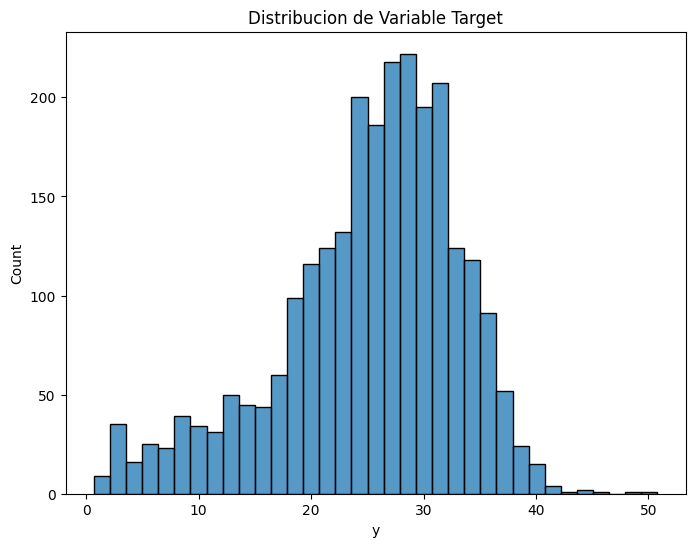

In [369]:
plt.figure(figsize=(8,6))
sns.histplot(restaurantes['y'])
plt.title(label='Distribucion de Variable Target')
plt.show() #distribución de variable Y

In [370]:
restaurantes.describe()

,lat,lon,dine_in,price_level,rating,reservable,serves_beer,serves_breakfast,serves_brunch,serves_dinner,serves_lunch,serves_vegetarian_food,serves_wine,takeout,user_ratings_total,delivery,price_level_mean,rating_mean,user_ratings_mean,apt_municip_mayores,asocia_sec_1,asocia_cult_casas_reg,asocia_mujeres,asocia_vecinales,anio_medio_constr_vivendas,bibliotecas_comunidad,bibliotecas_municipal,bibliotecas_comunidad_public,bibliotecas_municipal_public,campus_futb_11,centro_ninos_3_12_anios,centro_municipal_mayor,cmsc,aspa,caf,cai,cad_y_ccad,centro_dia_alzheimer_fisicos,centro_serv_social,centro_deport_municipal,centro_pers_sin_hogar,centro_espacio_cultural,colegio_publ_infatil_primaria,dur_media_credito_viviendas,edad_media_poblacion,votos_blancos_elec_municipal,abstenciones_elec_municipal,censo_elec_municipal,votos_ciudadanos_elec_municipal,votos_masmadrid_elec_municipal,votos_masverdeequo_elec_municipal,votos_podemos_elec_municipal,votos_vox_elec_municipal,votos_candidaturas_elec_municipal,votos_pp_elec_municipal,votos_psoe_elec_municipal,escuelas_inf_municipal,espacio_igualdad,espacio_adolecentes_ocio,esperanza_vida_hombres,esperanza_vida_mujeres,etapa_educativa_ninas,etapa_educativa_ninos,fundacion_sec_2,hogar_hombre_mas_65,hogar_mujer_mas_65,hogar_monoparental_hombre,hogar_monoparental_mujer,instalaciones_deportivas_basc,inst_publico_secundaria,mercado_municipales,num_habitantes,num_inmuebles_residencial,num_locales_alta_abiertos,num_locales_alta_cerrados,num_locales_alta_obra,num_locales_alta_vivienda,num_locales_alta_tot,parados,parados_hombre,parados_mujer,pension_media_mensual_mujeres,pension_media_mensual_hombres,personas_espanolas,personas_espanolas_hombre,personas_espanolas_mujer,personas_extranjera,personas_extranjera_hombre,personas_extranjera_mujer,piscina_cubierta,piscina_verano,pista_atletismo,poblacion_hombre,poblacion_mujer,poblacion_0_14,poblacion_15_29,poblacion_30_44,poblacion_45_64,poblacion_65_79,poblacion_65_mas,poblacion_80_mas,poblacion_densidad,poblacion_etapa_educativa_0_2,poblacion_etapa_educativa_12_15,poblacion_etapa_educativa_3_5,poblacion_etapa_educativa_6_11,poblacion_etapa_educativa,poblacion_etapa_educativa_0_2_mujer,poblacion_etapa_educativa_12_15_mujer,poblacion_etapa_educativa_3_5_mujer,poblacion_etapa_educativa_6_11_mujer,poblacion_etapa_educativa_0_2_hombre,poblacion_etapa_educativa_12_15_hombre,poblacion_etapa_educativa_3_5_hombre,poblacion_etapa_educativa_6_11_hombre,pobl_25_mas_est_superiores,pobl_25_mas_no_letrados,pobl_25_mas_bachiller_eso_fp1,pobl_25_mas_bachillersup_fp2,pobl_25_mas_estudio_desconocido,pobl_25_mas_primaria_incompleta,pobl_25_titu_media,pct_evejecimiento,pct_sobrevejecimiento,posicion_ranking_vulnerabilidad,poblacion_bangladesh,poblacion_bolivia,poblacion_china,poblacion_ecuador,poblacion_filipinas,poblacion_francia,poblacion_italia,poblacion_paraguay,poblacion_peru,poblacion_rumania,poblacion_venezuela,poblacion_colombia,poblacion_francia,poblacion_honduras,pct_migrantes(personas_extranjeras_menos_UE/poblacion_total),pct_migrantes(poblacion_extranjeras_menos_UE/poblacion_total),renta_media_persona,renta_neta_anual_hogar,residencia_mayores,superficie,superficie_media_residencias,superficie_media_vivienda_transac,tamano_hogar_medio,pct_abs_paro,pct_abs_paro_hombre,pct_abs_paro_mujer,pct_bruta_natalidad,pct_crecimiento_demografico,pct_desempleo_hombre_16-24,pct_desempleo_hombre_25-44,pct_desempleo_hombre_45-64,pct_desempleo_mujer_16-24,pct_desempleo_mujer_25-44,pct_desempleo_mujer_45-64,tot_hogares,valor_catast_inmueble_residen,indice_vulnerabilidad_bienestar_social_igual,indice_vulnerabilidad_eco_empleo,indice_vulnerabilidad_edu_cultura,indice_vulnerabilidad_ambiente_urbano y movi,indice_vulnerabilidad_salud,indice_vulnerabilidad_territorial,indice_dependiencia(bebes y aldutos mayores/pob 16-64),Americana / Burgers,Asiática,China,Española,Fusión,Italiana,Japonesa,Latinoamericana,Mexicana,Otros,Arganzuela,Carabanchel,Centro,Chamartín,Chamberí,Ciudad Lineal,Fuencarral - E

In [371]:
corr = restaurantes.corr(numeric_only=True)
corr

,lat,lon,dine_in,price_level,rating,reservable,serves_beer,serves_breakfast,serves_brunch,serves_dinner,serves_lunch,serves_vegetarian_food,serves_wine,takeout,user_ratings_total,delivery,price_level_mean,rating_mean,user_ratings_mean,apt_municip_mayores,asocia_sec_1,asocia_cult_casas_reg,asocia_mujeres,asocia_vecinales,anio_medio_constr_vivendas,bibliotecas_comunidad,bibliotecas_municipal,bibliotecas_comunidad_public,bibliotecas_municipal_public,campus_futb_11,centro_ninos_3_12_anios,centro_municipal_mayor,cmsc,aspa,caf,cai,cad_y_ccad,centro_dia_alzheimer_fisicos,centro_serv_social,centro_deport_municipal,centro_pers_sin_hogar,centro_espacio_cultural,colegio_publ_infatil_primaria,dur_media_credito_viviendas,edad_media_poblacion,votos_blancos_elec_municipal,abstenciones_elec_municipal,censo_elec_municipal,votos_ciudadanos_elec_municipal,votos_masmadrid_elec_municipal,votos_masverdeequo_elec_municipal,votos_podemos_elec_municipal,votos_vox_elec_municipal,votos_candidaturas_elec_municipal,votos_pp_elec_municipal,votos_psoe_elec_municipal,escuelas_inf_municipal,espacio_igualdad,espacio_adolecentes_ocio,esperanza_vida_hombres,esperanza_vida_mujeres,etapa_educativa_ninas,etapa_educativa_ninos,fundacion_sec_2,hogar_hombre_mas_65,hogar_mujer_mas_65,hogar_monoparental_hombre,hogar_monoparental_mujer,instalaciones_deportivas_basc,inst_publico_secundaria,mercado_municipales,num_habitantes,num_inmuebles_residencial,num_locales_alta_abiertos,num_locales_alta_cerrados,num_locales_alta_obra,num_locales_alta_vivienda,num_locales_alta_tot,parados,parados_hombre,parados_mujer,pension_media_mensual_mujeres,pension_media_mensual_hombres,personas_espanolas,personas_espanolas_hombre,personas_espanolas_mujer,personas_extranjera,personas_extranjera_hombre,personas_extranjera_mujer,piscina_cubierta,piscina_verano,pista_atletismo,poblacion_hombre,poblacion_mujer,poblacion_0_14,poblacion_15_29,poblacion_30_44,poblacion_45_64,poblacion_65_79,poblacion_65_mas,poblacion_80_mas,poblacion_densidad,poblacion_etapa_educativa_0_2,poblacion_etapa_educativa_12_15,poblacion_etapa_educativa_3_5,poblacion_etapa_educativa_6_11,poblacion_etapa_educativa,poblacion_etapa_educativa_0_2_mujer,poblacion_etapa_educativa_12_15_mujer,poblacion_etapa_educativa_3_5_mujer,poblacion_etapa_educativa_6_11_mujer,poblacion_etapa_educativa_0_2_hombre,poblacion_etapa_educativa_12_15_hombre,poblacion_etapa_educativa_3_5_hombre,poblacion_etapa_educativa_6_11_hombre,pobl_25_mas_est_superiores,pobl_25_mas_no_letrados,pobl_25_mas_bachiller_eso_fp1,pobl_25_mas_bachillersup_fp2,pobl_25_mas_estudio_desconocido,pobl_25_mas_primaria_incompleta,pobl_25_titu_media,pct_evejecimiento,pct_sobrevejecimiento,posicion_ranking_vulnerabilidad,poblacion_bangladesh,poblacion_bolivia,poblacion_china,poblacion_ecuador,poblacion_filipinas,poblacion_francia,poblacion_italia,poblacion_paraguay,poblacion_peru,poblacion_rumania,poblacion_venezuela,poblacion_colombia,poblacion_francia,poblacion_honduras,pct_migrantes(personas_extranjeras_menos_UE/poblacion_total),pct_migrantes(poblacion_extranjeras_menos_UE/poblacion_total),renta_media_persona,renta_neta_anual_hogar,residencia_mayores,superficie,superficie_media_residencias,superficie_media_vivienda_transac,tamano_hogar_medio,pct_abs_paro,pct_abs_paro_hombre,pct_abs_paro_mujer,pct_bruta_natalidad,pct_crecimiento_demografico,pct_desempleo_hombre_16-24,pct_desempleo_hombre_25-44,pct_desempleo_hombre_45-64,pct_desempleo_mujer_16-24,pct_desempleo_mujer_25-44,pct_desempleo_mujer_45-64,tot_hogares,valor_catast_inmueble_residen,indice_vulnerabilidad_bienestar_social_igual,indice_vulnerabilidad_eco_empleo,indice_vulnerabilidad_edu_cultura,indice_vulnerabilidad_ambiente_urbano y movi,indice_vulnerabilidad_salud,indice_vulnerabilidad_territorial,indice_dependiencia(bebes y aldutos mayores/pob 16-64),Americana / Burgers,Asiática,China,Española,Fusión,Italiana,Japonesa,Latinoamericana,Mexicana,Otros,Arganzuela,Carabanchel,Centro,Chamartín,Chamberí,Ciudad Lineal,Fuencarral - E

In [372]:
''' 
Evaluamos las correlaciones y nos quedamos con las variables que tengan un correlacion >=(abs(0.2))
'''

val = corr[(corr['y']>=0.2)|(corr['y']<=-0.2)].sort_values(by='y')

#val.to_excel('../data/raw/correlaciones.xlsx') 

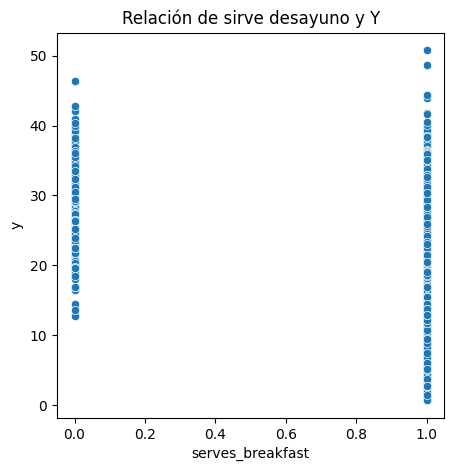

In [373]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['serves_breakfast'])
plt.title(label='Relación de sirve desayuno y Y')
plt.xlabel('serves_breakfast')
plt.ylabel('y')
plt.show()

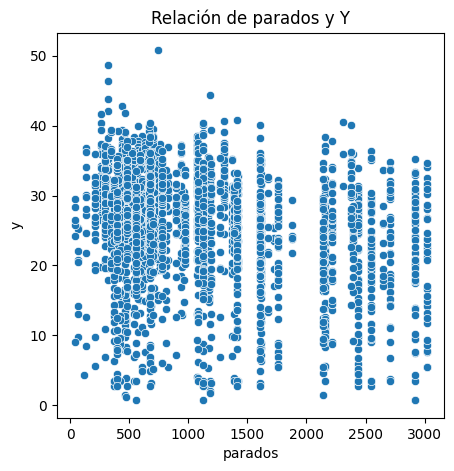

In [374]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['parados'])
plt.title(label='Relación de parados y Y')
plt.xlabel('parados')
plt.ylabel('y')
plt.show()

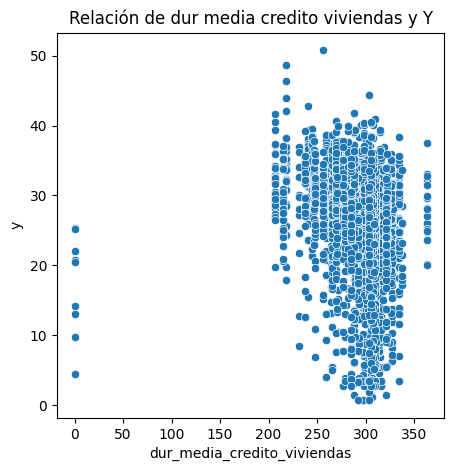

In [375]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['dur_media_credito_viviendas'])
plt.title(label='Relación de dur media credito viviendas y Y')
plt.xlabel('dur_media_credito_viviendas')
plt.ylabel('y')
plt.show()

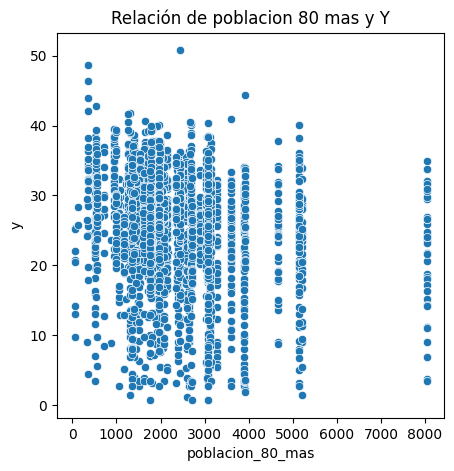

In [376]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['poblacion_80_mas'])
plt.title(label='Relación de poblacion 80 mas y Y')
plt.xlabel('poblacion_80_mas')
plt.ylabel('y')
plt.show()

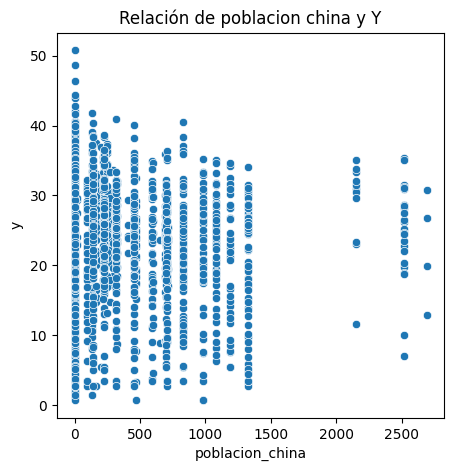

In [377]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['poblacion_china'])
plt.title(label='Relación de poblacion china y Y')
plt.xlabel('poblacion_china')
plt.ylabel('y')
plt.show()

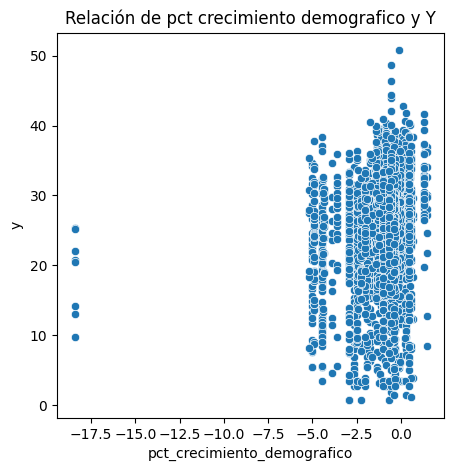

In [378]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['pct_crecimiento_demografico'])
plt.title(label='Relación de pct crecimiento demografico y Y')
plt.xlabel('pct_crecimiento_demografico')
plt.ylabel('y')
plt.show()

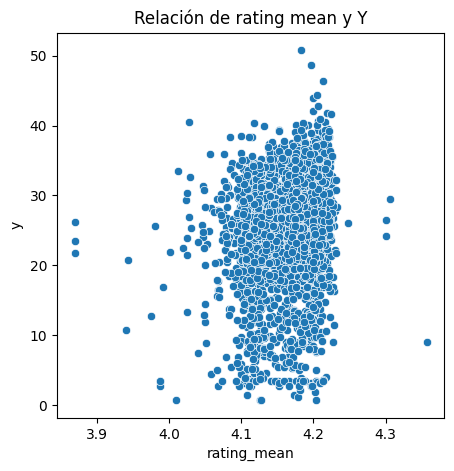

In [379]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['rating_mean'])
plt.title(label='Relación de rating mean y Y')
plt.xlabel('rating_mean')
plt.ylabel('y')
plt.show()

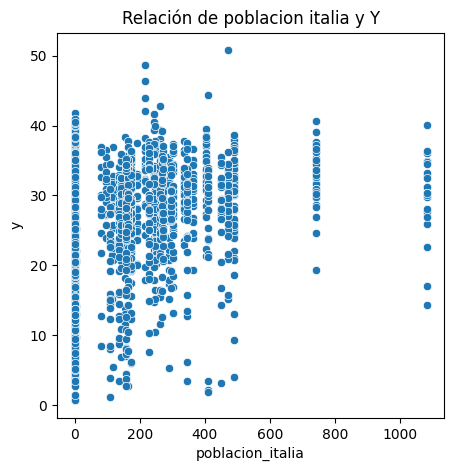

In [380]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['poblacion_italia'])
plt.title(label='Relación de poblacion italia y Y')
plt.xlabel('poblacion_italia')
plt.ylabel('y')
plt.show()

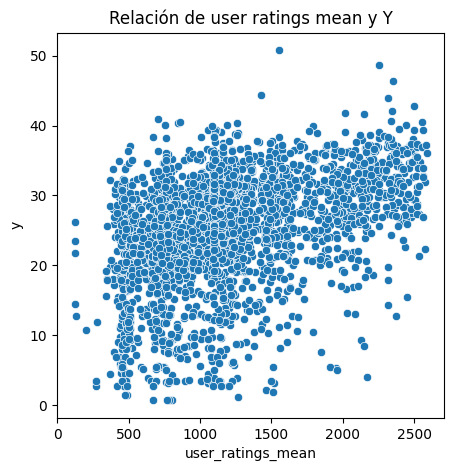

In [381]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['user_ratings_mean'])
plt.title(label='Relación de user ratings mean y Y')
plt.xlabel('user_ratings_mean')
plt.ylabel('y')
plt.show()

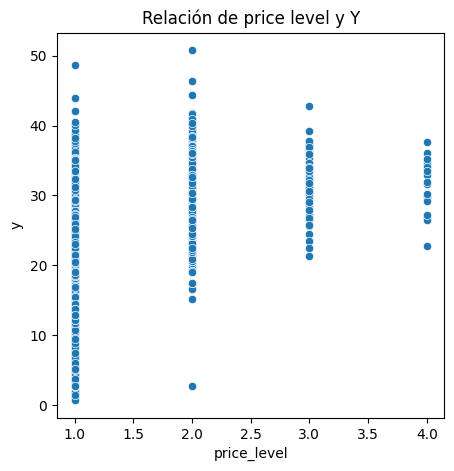

In [382]:
plt.figure(figsize=(5,5))
sns.scatterplot(y=restaurantes['y'], x=restaurantes['price_level'])
plt.title(label='Relación de price level y Y')
plt.xlabel('price_level')
plt.ylabel('y')
plt.show()

In [383]:
restaurantes.to_csv('../data/processed/restaurantes.csv', index=False)